# Agent Evaluation Using LLM

This notebook evaluates the performance of a data analysis agent by comparing its responses against ground truth answers using Phoenix for experiment tracking and LLM-based assessment.

## Imports and Setup

Import required libraries and configure the environment

In [14]:
"""Evaluation module for testing the data analysis agent.

This module provides functionality to evaluate the performance of the data analysis agent
by comparing its responses against a ground truth dataset. It uses Phoenix for experiment
tracking and provides automated testing across a wide range of query types.

The evaluation approach uses LLM-based assessment to determine if the agent's responses
correctly answer the test questions, with substring matching as a fallback method.
"""

#==============================================================================
# IMPORTS
#==============================================================================
import os
import sys
import time
from pathlib import Path

# Apply nest_asyncio at the very top before any other async operations
import nest_asyncio
nest_asyncio.apply()

import pandas as pd
import matplotlib.pyplot as plt
from pycm import ConfusionMatrix  # Add pycm for confusion matrix
from sklearn.metrics import classification_report
from phoenix.evals import OpenAIModel, QA_PROMPT_TEMPLATE, QA_PROMPT_RAILS_MAP, llm_classify
from phoenix.experiments import run_experiment
from phoenix.experiments.types import EvaluationResult
from phoenix.session.client import Client
from typing import Dict, Any, List

# -------------------------------------------------------------------
# Ensure prototype4 root (parent of Evaluations) is on sys.path
# -------------------------------------------------------------------
# Simple path resolution for notebook environment
import os
from pathlib import Path

# Get current working directory and go up one level to find project root
NOTEBOOK_DIR = Path(os.getcwd()).resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent if 'Evaluations' in str(NOTEBOOK_DIR) else NOTEBOOK_DIR

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
# -------------------------------------------------------------------

from main import main

## Test Data

Ground truth data used for evaluating agent responses

In [2]:
#==============================================================================
# CONSTANTS & CONFIGURATION
#==============================================================================
# Test data with expected ground truth answers
# Prepare test data
agent_ground_truth = {
    # Basic Retrieval
    # "What is the amount of men in Prague at the end of Q3 2024?": "676069",
#     "What is the amount of women in Prague at the end of Q3 2024?": "716056",
#     "What is the amount of women in Zlin region at the end of Q3 2024?": "294996",    
#     "What was the total population of Czech Republic at the start of Q1-Q3 2024?": "10900555",
# 	"Show me the female population in South Moravia at mid-2024?": "625214",
# 	"What was the middle-period population count for Zlín Region?": "579562",
	
# 	# Comparisons
# 	"Did Prague have more residents than Central Bohemia at the start of 2024?": "No (1384732 < 1455940)",
# 	"Which region had higher female population - Liberec or Karlovy Vary at period end?": "Liberec (228648 > 150270)",
#     "List regions where mid-period male population exceeded 300,000": "Česko, Prague, Central Bohemia, Ústí, South Moravia, Moravian-Silesia",
#     "Was there any quarter where Plzeň's women outnumbered men by >15,000?": "No (max difference 11235)",
    
#     # Aggregations
#     "What was the average male population across all regions at period end?": "≈326000",
#     "Which region had the lowest total population at the end of Q3?": "Karlovy Vary (293218)",
#     "Count how many regions had <500k total residents mid-period": "5 (Karlovy Vary, Liberec, Vysočina, Olomouc, Zlín)",
#     "What was the maximum female population recorded in any region?": "716056 (Prague)",
    
#     # Temporal/Deltas
#     "How much did Prague's population grow from start to end of Q3?": "+7393",
#     "Calculate percentage change in Ústí's male population (start vs end)": "-0.37%",
#     "Which region had the steepest population decline?": "Moravian-Silesia (-5730)",
#     "What was South Bohemia's population change rate per month?": "-386/month",
    
#     # Demographic Ratios
#     "What percentage of Pardubice region was female at mid-period?": "50.57%",
#     "What was the male:female ratio in Vysočina at period start?": "0.985",
#     "Which region had the most balanced gender ratio at period end?": "Vysočina (50.7% female)",
#     "How many women per 100 men in Olomouc at mid-year?": "104.4",
    
    # Complex Joins/Logic
    "Compare Prague's start vs end population for men and women": "Men: +5389, Women: +2004",
    "Rank regions by population growth rate from start to end": "1. Prague (+0.53%), 2. Central Bohemia (+0.46%)...",
    "List regions where women population decreased >1000": "Ústí (-1466), Moravian-Silesia (-3299)",
    "Show regions where mid-period population was < start but > end": "None (no such cases)",
    
    # Edge Cases
    "What if Karlovy Vary had no data for mid-period women count?": "NULL",
    "Show regions with exactly 500,000 residents at any point": "There are no such regions",
    "Find records where male count equals female count": "None",
    "List regions with unreported start-period data": "None (all reported)",
    "What was Brno's population?": "[Brno not listed as separate region]",
    "Current male population in undefined 'North Region'": "[Region doesn't exist]",
    
#     # Negative/Inverse Queries
#     "Which regions did NOT experience population decline?": "Prague, Central Bohemia, South Moravia",
#     "Were there any quarters where no region had growing population?": "No",
#     "List regions where women count never exceeded men count": "None",
    
#     # Imprecise Phrasings
#     "Tell me approximate folks count in Plzeň around mid-year": "≈612025",
#     "What's the rough male population in Bohemia regions combined?": "≈2.1M",
#     "How many people in that big eastern wine region?": "South Moravia ≈1.23M",
    
#     # Boundary Testing
#     "Show regions with population between 500k-600k at end": "Plzeň (613109), Vysočina (517664), Olomouc (631688)",
#     "Which region's population is closest to 400k?": "Liberec (449261)",
#     "First 3 regions alphabetically with >700k population": "Central Bohemia, Moravian-Silesia, South Moravia",
    
#     # Calculation Heavy
#     "What was the national population density assuming 78,866 km² area?": "≈138/km²",
#     "Calculate gender imbalance index (|M-F|/total) for Zlín at end": "0.0186",
#     "Sum all regional end-period populations - does it match Česko?": "10897237 vs 10897237 (matches)",
    
#     # Time Logic
#     "Project annual growth if Q1-Q3 trend continues for Prague": "≈+9857/year",
#     "When would Karlovy Vary reach 250k residents at current rate?": "Never (declining)",
#     "Compare Q3 2024 growth to same period in hypothetical 2023": "[No 2023 data]",
    
#     # Exception Testing
#     "Query population for non-existent 'West Bohemia' region": "[Region doesn't exist]",
#     "Show data for time period not in dataset (Q4 2024)": "[No data]",
#     "What was population before recorded history?": "[No data]",
    
#     # Multi-Metric
#     "For Vysočina, show start/mid/end counts for both genders": "Start: 257012M/260948F, Mid: 256873M/260373F, End: 257229M/260435F",
#     "Compare Prague and Brno demographics": "[Brno data not separate from South Moravia]",
}

## Dataset Preparation and Helper Functions

Functions for dataset management and preparation of test data

In [4]:
def get_or_create_dataset(
    client: Client, 
    name: str, 
    data_df: pd.DataFrame, 
    input_keys: List[str] = ["question"], 
    output_keys: List[str] = ["context"]
) -> Any:
    """
    Get existing dataset or create new one if it doesn't exist.
    
    This function handles the management of Phoenix datasets by:
    1. Checking if the dataset already exists
    2. Identifying new records that need to be added
    3. Either creating a new dataset or appending to the existing one
    
    Args:
        client: Phoenix client instance
        name: Name of the dataset to get or create
        data_df: DataFrame containing the test data
        input_keys: Column names to use as inputs
        output_keys: Column names to use as outputs
        
    Returns:
        Phoenix dataset object
    """
    
    try:
        dataset = client.get_dataset(name=name)
        print("Found existing dataset")
        
        existing_df = dataset.as_dataframe()
        current_questions = [row['input'][input_keys[0]] for _, row in existing_df.iterrows()]

        new_records = data_df[~data_df[input_keys[0]].isin(current_questions)]

        if len(new_records) > 0:
            print(f"Appending {len(new_records)} new records")
            dataset = client.append_to_dataset(
                dataset_name=name,
                dataframe=new_records,
                input_keys=input_keys,
                output_keys=output_keys
            )
        else:
            print("No new records to append")
            
        return dataset
    except (ValueError, Exception):
        print("Creating new dataset")
        return client.upload_dataset(
            dataset_name=name,
            dataframe=data_df,
            input_keys=input_keys,
            output_keys=output_keys
        )

# Prepare the dataset for Phoenix
def prepare_dataset():
    """Prepare the dataset for Phoenix evaluation.
    
    This function:
    1. Initializes the Phoenix client
    2. Converts the ground truth data to a DataFrame
    3. Creates or updates the Phoenix dataset
    
    Returns:
        Phoenix dataset object and client
    """
    # Initialize Phoenix client
    px_client = Client(warn_if_server_not_running=True)

    # Convert to DataFrame with correct column names for Phoenix QA eval
    new_data_df = pd.DataFrame(agent_ground_truth.items(), columns=["question", "context"])
    dataset_name = "agent_output_evaluation_langchain10"

    # Get or create dataset with updated input/output keys
    dataset = get_or_create_dataset(
        px_client,
        dataset_name,
        new_data_df,
        input_keys=["question"],
        output_keys=["context"]
    )

    # Show final state
    final_df = dataset.as_dataframe()
    print(f"\nFinal dataset has {len(final_df)} records")
    
    return dataset, px_client

# Get the prepared dataset and Phoenix client
dataset, px_client = prepare_dataset()

c:\Users\mmiscanuk\AppData\Local\anaconda3\envs\prototype4b\Lib\site-packages\phoenix\utilities\client.py:60: UserWarning: The Phoenix server (8.27.0) and client (8.29.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


Found existing dataset
No new records to append

Final dataset has 10 records


## Task Function for Phoenix

Async function that runs the agent on test questions

In [5]:
async def task(input_data: Dict[str, Any]) -> Dict[str, Any]:
    """Phoenix async task function that runs the agent on a single test question.
    
    This function serves as the task executor for Phoenix experiments, taking
    a single input question and running the agent against it, capturing results
    or any errors that occur.
    
    Args:
        input_data: Dictionary containing the test question
        
    Returns:
        Dictionary with the query, results, and any errors
    """
    question = input_data["question"]
    try:
        # Execute the main function directly (not in a thread)
        # as we're already in an async context
        result = main(prompt=question)
        return {
            "query": question,
            "results": result["result"],
            "error": None
        }
    except Exception as e:
        # Capture any errors for better debugging
        return {
            "query": question,
            "results": f"Error occurred: {str(e)}",
            "error": str(e)
        }

## LLM-Based Evaluator

Evaluation function using Azure OpenAI to assess agent responses

In [6]:
def qa_llm_evaluator(output: dict, reference: dict) -> EvaluationResult:
    """Use AzureChatOpenAI deployment to judge correctness using Phoenix llm_classify.
    
    This function performs an LLM-based evaluation to determine if the agent's response
    correctly answers the question based on the reference ground truth. It falls back
    to substring matching if the LLM evaluation fails.
    
    Args:
        output: Dictionary containing the agent's output
        reference: Dictionary containing the reference ground truth
        
    Returns:
        EvaluationResult object with the evaluation results
    """
    answer = str(output.get("results", ""))
    question = output.get("query", "")
    context = str(reference.get("context", ""))

    # Create DataFrame with column names matching the template variables
    df_eval = pd.DataFrame({
        "input": [question],          # Template variable - matches QA_PROMPT_TEMPLATE
        "reference": [context],       # Template variable - matches QA_PROMPT_TEMPLATE
        "output": [answer]            # Template variable - matches QA_PROMPT_TEMPLATE
    })

    # Configure OpenAIModel for Azure - using the correct parameters
    model = OpenAIModel(
        model="gpt-4o__test1",        # For Azure, this is the deployment name
        api_version="2024-05-01-preview",
        azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
        api_key=os.getenv('AZURE_OPENAI_API_KEY'),
        temperature=0.0
    )

    rails = list(QA_PROMPT_RAILS_MAP.values())

    try:
        eval_df = llm_classify(
            data=df_eval,             # Use 'data' instead of deprecated 'dataframe'
            template=QA_PROMPT_TEMPLATE,
            model=model,
            rails=rails,
            provide_explanation=True
        )

        label = eval_df["label"].iloc[0]
        score = 1 if label == "correct" else 0
        explanation = eval_df["explanation"].iloc[0]
    except Exception as e:
        # Graceful error handling if Phoenix still has issues
        print(f"Phoenix evaluation failed: {e}")
        # Fall back to a simple substring match
        if context in answer:
            label = "correct"
            score = 1
            explanation = "Answer contains the expected value (fallback evaluation)."
        else:
            label = "incorrect"
            score = 0
            explanation = "Answer does not contain the expected value (fallback evaluation)."
    
    return EvaluationResult(label=label, score=score, explanation=explanation)

## Run Experiment

Function to run the evaluation experiment

In [ ]:
def run_evaluation():
    """Main function to run the evaluation experiment.
    
    This function:
    2. Runs the experiment with the appropriate evaluators
    3. Returns the experiment results
    
    Returns:
        Phoenix experiment object
    """

    # Run the experiment with the new LLM evaluator
    try:
        test_experiment = run_experiment(
            dataset,
            task=task,
            evaluators=[qa_llm_evaluator],
            concurrency=20, 
            experiment_name=f"agent_eval_{time.strftime('%Y%m%d_%H%M%S')}"
        )
        print(f"Experiment completed successfully. Experiment ID: {test_experiment.id}")
        return test_experiment
    except Exception as e:
        print(f"Error running experiment: {e}")
        raise
    
# Run the evaluation experiment
experiment = run_evaluation()

## Analysis of Results

Evaluating the performance of the agent through visualization and metrics

In [9]:
# Reset any previously set display options
pd.reset_option('^display.', silent=True)

In [10]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

In [11]:
# Display sample evaluation result
evaluations_df = experiment.get_evaluations()
print("\nTransposed view:")
print(evaluations_df.iloc[[8]].T)


Transposed view:
run_id                                RXhwZXJpbWVudFJ1bjoxMTk2
name                                          qa_llm_evaluator
score                                                        0
label                                                incorrect
explanation  The question asks for Brno's population. The r...
output       {'query': 'What was Brno's population?', 'resu...
input              {'question': 'What was Brno's population?'}
expected     {'context': '[Brno not listed as separate regi...
example_id                            RGF0YXNldEV4YW1wbGU6NDc1


## Visualization of Evaluation Results

Creating a confusion matrix and calculating performance metrics

              precision    recall  f1-score   support

     correct       1.00      0.40      0.57        10
   incorrect       0.00      0.00      0.00         0

    accuracy                           0.40        10
   macro avg       0.50      0.20      0.29        10
weighted avg       1.00      0.40      0.57        10

Total examples evaluated: 10
Correct predictions: 4 (40.00%)
Incorrect predictions: 6 (60.00%)


c:\Users\mmiscanuk\AppData\Local\anaconda3\envs\prototype4b\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mmiscanuk\AppData\Local\anaconda3\envs\prototype4b\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mmiscanuk\AppData\Local\anaconda3\envs\prototype4b\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

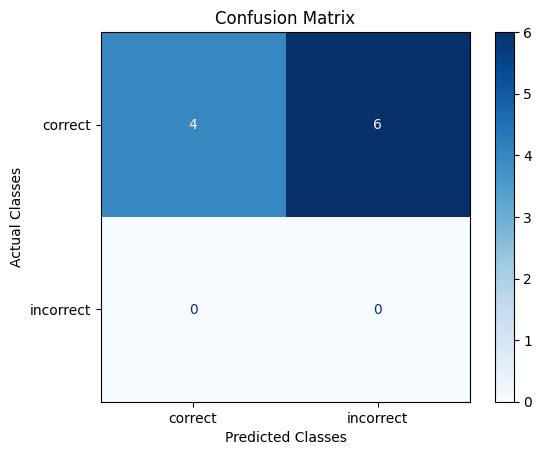

In [15]:
# Extract the labels from evaluations dataframe
y_true = ['correct'] * len(evaluations_df)  # We assume all expected answers should be correct
y_pred = evaluations_df['label'].tolist()  # Actual predictions (correct/incorrect)

# Calculate and display metrics using sklearn classification report
rails = list(QA_PROMPT_RAILS_MAP.values())  # Get the possible classification labels
print(classification_report(y_true, y_pred, labels=rails))

# Create confusion matrix using pycm (similar to benchmark notebook)
confusion_matrix = ConfusionMatrix(actual_vector=y_true, predict_vector=y_pred, classes=rails)

# Plot the confusion matrix
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=False,
)

# Calculate and display metrics
tp = len([p for t, p in zip(y_true, y_pred) if t == 'correct' and p == 'correct'])  # True positives
fp = len([p for t, p in zip(y_true, y_pred) if t == 'correct' and p == 'incorrect'])  # False positives

accuracy = tp / (tp + fp) * 100

print(f"Total examples evaluated: {len(evaluations_df)}")
print(f"Correct predictions: {tp} ({accuracy:.2f}%)")
print(f"Incorrect predictions: {fp} ({100-accuracy:.2f}%)")

## Additional Analysis

Space for further exploration and analysis of results

In [13]:
# Additional analysis code can be added here